## Import dependencies

In [1]:
!pip install osmnx networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.1 MB/s eta 0:00:00


In [7]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
from statistics import mean, stdev
import matplotlib.pyplot as plt

## Identifying 10 pairs of origin-destination nodes separated by a minimum distance of 5 km

In [3]:
city_name = "Natal, Rio Grande do Norte, Brazil"
graph = ox.graph_from_place(city_name, network_type="drive")

graph_proj = ox.project_graph(graph) # Coordinates in meters

In [4]:
def calculate_euclidean_distance(node1, node2, graph):
    x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
    x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
    return ox.distance.euclidean(y1, x1, y2, x2)

def generate_random_points(graph, num_pairs=10, min_distance=5000):
    nodes = list(graph.nodes)
    node_pairs = []

    for _ in range(num_pairs):
        while True:
            node1 = random.choice(nodes)
            node2 = random.choice(nodes)

            distance = calculate_euclidean_distance(node1, node2, graph)

            if distance >= min_distance:
                node_pairs.append((node1, node2))
                break
    return node_pairs

node_pairs = generate_random_points(graph_proj, num_pairs=10, min_distance=5000)

## Networkx shortest paths solution


Average execution time after 100 executions: 1.6702 seconds
Standard deviation: 0.3220 seconds


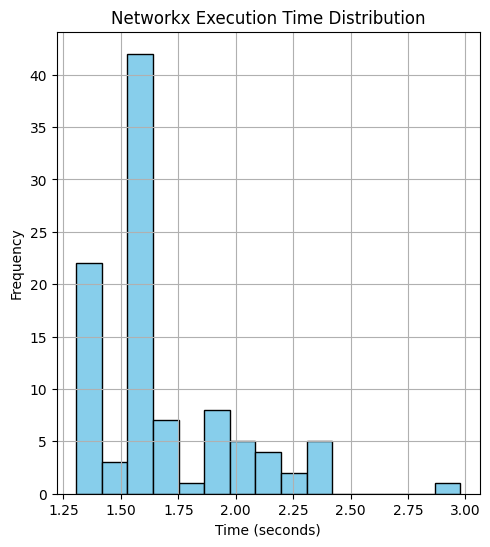

In [20]:
import time
import networkx as nx
from statistics import mean, stdev
import matplotlib.pyplot as plt

num_executions = 100

execution_times = []

for _ in range(num_executions):
    start = time.time()

    shortest_nx_paths = [
        nx.shortest_path(graph, source=pair[0], target=pair[1], weight="length")
        for pair in node_pairs
    ]

    end = time.time()
    execution_times.append(end - start)

average_time = mean(execution_times)
std_deviation = stdev(execution_times)

print(f"Average execution time after {num_executions} executions: {average_time:.4f} seconds")
print(f"Standard deviation: {std_deviation:.4f} seconds")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(execution_times, bins=15, color='skyblue', edgecolor='black')
plt.title('Networkx Execution Time Distribution')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


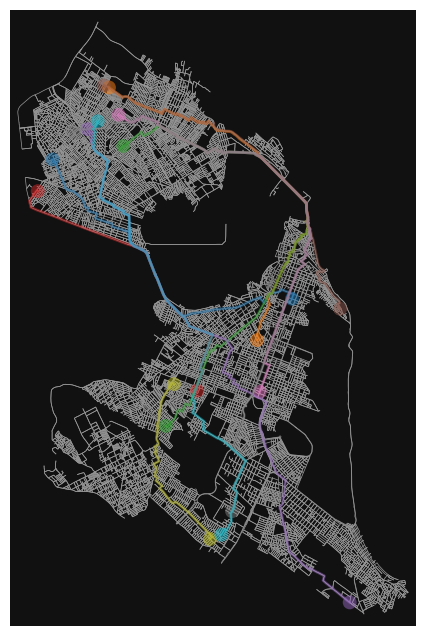

In [22]:
colors = ox.plot.get_colors(len(shortest_nx_paths), cmap="tab10")  # Generates different colors for the paths

fig, ax = ox.plot_graph(graph, edge_linewidth=0.5, node_size=0, show=False, close=False)

for path, color in zip(shortest_nx_paths, colors):
    ox.plot_graph_route(
        graph,
        path,
        route_color=color,
        route_linewidth=2,
        ax=ax,
        show=False,
        close=False,
    )

fig.show()


## Implementing Dijkstra's algorithm

### MinHeap

In [15]:
class MinHeap:
    """
    MinHeap class: Implements a MinHeap data structure to efficiently manage vertices and their distances
    for algorithms like Dijkstra. This implementation keeps track of the position of each vertex using
    a vertex map for constant-time lookups and updates.
    """
    def __init__(self, array):
        """
        Initializes the MinHeap with an input array of (vertex, distance) pairs.

        Args:
            array (list): List of tuples where each tuple is (vertex, distance).
                          The distance is typically initialized to infinity except for the starting vertex.

        Attributes:
            vertexMap (dict): Maps each vertex to its position in the heap for quick access.
            heap (list): List representing the binary heap as an array.
        """
        # Create a vertex map: Maps vertices to their indices in the heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Build the heap from the input array to satisfy the heap property.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Checks if the heap is empty.

        Returns:
            bool: True if the heap is empty, False otherwise.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Builds the heap from an input array in O(n) time.

        Args:
            array (list): List of (vertex, distance) pairs.

        Returns:
            list: The input array transformed into a valid MinHeap.
        """
        # Start from the first parent node and sift down each node.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restores the heap property by "sifting down" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift down.
            endIdx (int): Last index in the heap.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Index of the first child
        while childOneIdx <= endIdx:
            # Determine the index of the second child
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Choose the smaller child to maintain the min-heap property
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Swap if the child is smaller than the current node
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move to the swapped position
                childOneIdx = currentIdx * 2 + 1  # Update the first child index
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restores the heap property by "sifting up" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift up.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calculate parent index
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Swap with parent
            currentIdx = parentIdx  # Move to the parent's position
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Removes and returns the smallest element (root) in the heap.

        Returns:
            tuple: The (vertex, distance) pair with the smallest distance.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        if self.isEmpty():
            return None

        # Swap the root with the last element and remove it
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove the vertex from the map

        # Restore the heap property
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Swaps two nodes in the heap and updates their positions in the vertexMap.

        Args:
            i (int): Index of the first node.
            j (int): Index of the second node.
            heap (list): The heap array.
        """
        self.vertexMap[heap[i][0]] = j  # Update vertexMap for heap[i]
        self.vertexMap[heap[j][0]] = i  # Update vertexMap for heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Swap the nodes in the heap

    def update(self, vertex, value):
      """
      Atualiza o valor de um vértice na heap.
      """
      if vertex not in self.vertexMap:
          raise KeyError(f"Vértice {vertex} não encontrado na heap.")
      self.heap[self.vertexMap[vertex]] = (vertex, value)
      self.siftUp(self.vertexMap[vertex], self.heap)


### Dijstrak's Algorithm with Path


In [16]:
def dijkstrasAlgorithmWithPaths(start, edges):
    """
    Implements Dijkstra's algorithm to compute the shortest paths from a starting vertex to all other vertices
    in a weighted graph. It also tracks the predecessors of each vertex for path reconstruction.

    Args:
        start (int): The index of the starting vertex.
        edges (list of list): Adjacency list representation of the graph, where each index represents a vertex,
                              and each entry is a list of [destination, weight] pairs.

    Returns:
        tuple: A tuple containing:
            - minDistances (list): A list of the shortest distances from the starting vertex to each vertex.
                                   Vertices that are unreachable will have a distance of `float("inf")`.
            - previousNodes (list): A list where each index points to the predecessor of the vertex
                                    in the shortest path. If no path exists, the predecessor is `None`.

    Algorithm Steps:
        1. Initialize distances with `infinity` and set the starting vertex distance to 0.
        2. Use a MinHeap to manage and efficiently retrieve the vertex with the smallest known distance.
        3. For each vertex, relax its edges to update distances to neighboring vertices.
        4. Track the predecessor of each vertex to allow path reconstruction later.
        5. Return the minimum distances and the list of predecessors.
    """
    numberOfVertices = len(edges)  # Total number of vertices in the graph

    # Step 1: Initialize minimum distances and predecessors
    minDistances = [float("inf")] * numberOfVertices  # All distances set to infinity initially
    minDistances[start] = 0  # Distance to the start node is 0

    previousNodes = [None] * numberOfVertices  # Array to store the predecessor of each vertex

    # Step 2: Initialize the MinHeap
    heap = MinHeap([(i, float("inf")) for i in range(numberOfVertices)])
    heap.update(start, 0)  # Update the distance of the starting vertex to 0

    # Step 3: Process vertices until the heap is empty
    while not heap.isEmpty():

        # Extract the vertex with the smallest known distance
        vertex, currentMinDistance = heap.remove()

        # Ignore outdated distances (e.g., if a shorter distance was already found)
        if currentMinDistance > minDistances[vertex]:
            continue

        # Step 4: Relaxation - Update distances to neighboring vertices
        for edge in edges[vertex]:
            destination, weight = edge  # Extract destination vertex and edge weight

            # Calculate the new potential distance to the destination vertex
            newPathDistance = currentMinDistance + weight

            # Update if the new path is shorter
            if newPathDistance < minDistances[destination]:
                minDistances[destination] = newPathDistance
                previousNodes[destination] = vertex  # Track the predecessor for path reconstruction
                heap.update(destination, newPathDistance)  # Update the heap with the new distance

    return minDistances, previousNodes

### Reconstruct Path

In [17]:
def reconstructPath(previousNodes, start, end):
    """
    Reconstructs the shortest path from the start node to the end node using the predecessor list.

    Args:
        previousNodes (list): A list where each index corresponds to a node, and the value at that index
                              is the predecessor node in the shortest path. `None` indicates no predecessor.
        start (int): The starting node index.
        end (int): The destination node index.

    Returns:
        list: A list of nodes representing the shortest path from the start node to the end node.
              If no path exists, returns an empty list.

    Algorithm:
        1. Start from the destination node (`end`) and trace back to the start node (`start`) using
           the `previousNodes` list.
        2. Append each node encountered to the `path` list.
        3. Reverse the `path` list to produce the correct order from start to end.
        4. If no valid path exists (e.g., disconnected graph), return an empty list.

    Example:
        previousNodes = [None, 0, 1, 2]  # Predecessor list
        start = 0
        end = 3
        reconstructPath(previousNodes, start, end) -> [0, 1, 2, 3]
    """
    path = []  # Initialize an empty list to store the path
    currentNode = end  # Start tracing from the destination node

    # Step 1: Trace back from the destination node to the start node
    while currentNode is not None and currentNode != start:
        path.append(currentNode)  # Add the current node to the path
        currentNode = previousNodes[currentNode]  # Move to the predecessor node

    # Step 2: Add the start node if a valid path was found
    if currentNode == start:
        path.append(start)  # Add the start node to the path
        path.reverse()  # Reverse the path to get the correct order from start to end
        return path

    # Step 3: If no path exists, return an empty list
    return []


## Dijkstra shortest paths solution with min heap

In [18]:
nodes = list(graph.nodes)
node_idx_map = {node: idx for idx, node in enumerate(nodes)}
edges = [[] for _ in nodes]

for node in nodes:
    for neighbor, edge_data in graph[node].items():
        for _, data in edge_data.items():
            weight = data.get("length", 1)  # Use 'length' as weight (or 1 as pattern)
            if neighbor in node_idx_map:
                edges[node_idx_map[node]].append([node_idx_map[neighbor], weight])

Average execution time after 100 executions: 3.5092 seconds
Standard deviation: 0.6901 seconds


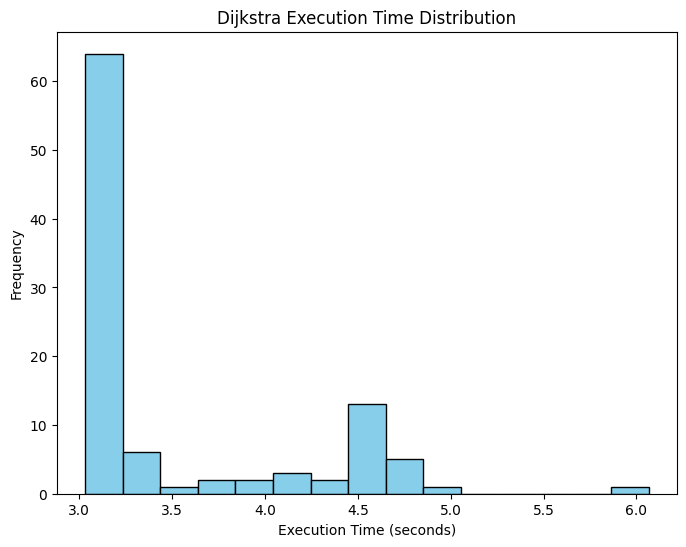

In [23]:
num_executions = 100

execution_times = []

for _ in range(num_executions):
    map_indexes = []

    start_time = time.time()

    # Code snippet to measure
    for pair in node_pairs:
        minDistances, previousNodes = dijkstrasAlgorithmWithPaths(node_idx_map[pair[0]], edges)
        path = reconstructPath(previousNodes, node_idx_map[pair[0]], node_idx_map[pair[1]])
        map_indexes.append(path)

    end_time = time.time()
    execution_times.append(end_time - start_time)

# Calculating statistics
average_time = mean(execution_times)
std_deviation = stdev(execution_times)

print(f"Average execution time after {num_executions} executions: {average_time:.4f} seconds")
print(f"Standard deviation: {std_deviation:.4f} seconds")

# Plotting the distribution
plt.figure(figsize=(8, 6))

# Histogram of execution times
plt.hist(execution_times, bins=15, color='skyblue', edgecolor='black')
plt.title('Dijkstra Execution Time Distribution')
plt.xlabel('Execution Time (seconds)')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [24]:
shortest_dijkstra_paths = []

for indexes in map_indexes:
  path = [nodes[idx] for idx in indexes]
  shortest_dijkstra_paths.append(path)

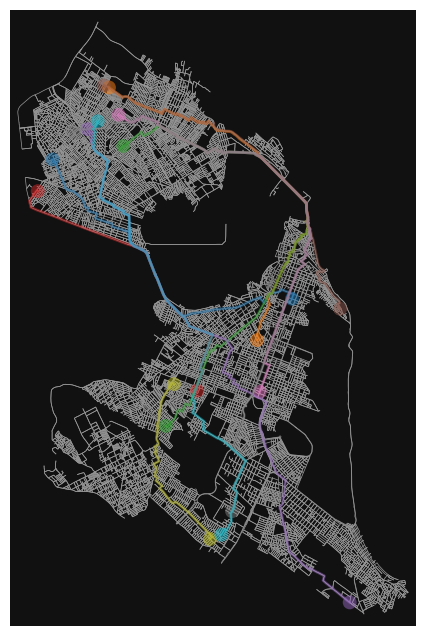

In [25]:
colors = ox.plot.get_colors(len(shortest_dijkstra_paths), cmap="tab10")  # Generates different colors for the paths

fig, ax = ox.plot_graph(graph, edge_linewidth=0.5, node_size=0, show=False, close=False)

for path, color in zip(shortest_dijkstra_paths, colors):
    ox.plot_graph_route(
        graph,
        path,
        route_color=color,
        route_linewidth=2,
        ax=ax,
        show=False,
        close=False,
    )

fig.show()